<a href="https://colab.research.google.com/github/rsakm/HealthSense-AI-Multiple-Diseases-Prediction-ML/blob/master/Notebooks/Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Loading Data ===

=== Data Summary ===
Shape: (768, 9)

Missing Values:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Class Distribution:
Outcome
0    500
1    268
Name: count, dtype: int64

=== Handling Zero Values ===

=== Handling Class Imbalance ===
Resampled class distribution: Outcome
1    500
0    500
Name: count, dtype: int64

=== Model Training ===
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

Cross-Validation Accuracy: 0.80 (±0.06)

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       100
           1       0.78      0.84      0.81       100

    accuracy                          

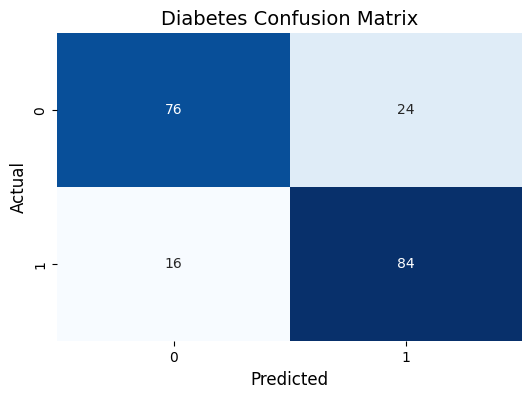

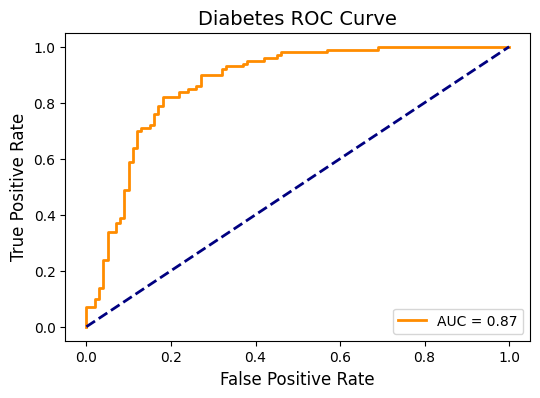


=== Feature Importance ===

Permutation Importance:
                    Feature  Importance
1                   Glucose      0.1075
5                       BMI      0.0795
7                       Age      0.0700
2             BloodPressure      0.0385
3             SkinThickness      0.0380
4                   Insulin      0.0320
6  DiabetesPedigreeFunction      0.0090
0               Pregnancies      0.0080


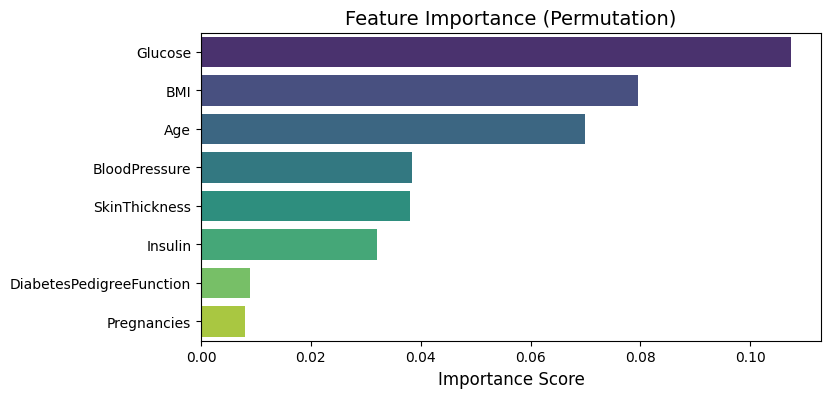


=== Saving Artifacts ===

Model, scaler and metadata saved successfully!

=== Sample Prediction ===

Sample Input Values:
[[  6.         148.          72.          35.         155.54822335
   33.6          0.627       50.        ]]

Prediction: Diabetic
Probability: 81.19%


In [1]:
# DIABETES PREDICTION SYSTEM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report,
                           confusion_matrix, roc_curve, auc)
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
import pickle
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# ======================
# DATA LOADING & PREP
# ======================
print("\033[1m" + "=== Loading Data ===" + "\033[0m")
diabetes = pd.read_csv('diabetes.csv')

# Data summary
print("\n\033[1m" + "=== Data Summary ===" + "\033[0m")
print(f"Shape: {diabetes.shape}")
print("\nMissing Values:")
print(diabetes.isnull().sum())
print("\nClass Distribution:")
print(diabetes['Outcome'].value_counts())

# Handle zero values in key features
print("\n\033[1m" + "=== Handling Zero Values ===" + "\033[0m")
zero_fields = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
diabetes[zero_fields] = diabetes[zero_fields].replace(0, np.nan)
diabetes.fillna(diabetes.mean(), inplace=True)

# Feature engineering
diabetes['BMI_Category'] = pd.cut(diabetes['BMI'],
                                bins=[0, 18.5, 25, 30, 100],
                                labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# ======================
# PREPROCESSING
# ======================
X = diabetes.drop(['Outcome', 'BMI_Category'], axis=1)
y = diabetes['Outcome']

# Handle class imbalance
print("\n\033[1m" + "=== Handling Class Imbalance ===" + "\033[0m")
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print("Resampled class distribution:", pd.Series(y_res).value_counts())

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# ======================
# MODEL TRAINING
# ======================
print("\n\033[1m" + "=== Model Training ===" + "\033[0m")
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

model = GridSearchCV(SVC(probability=True),
                    param_grid,
                    cv=5,
                    scoring='accuracy',
                    n_jobs=-1,
                    verbose=1)
model.fit(X_train, y_train)

print("\n\033[1mBest Parameters:\033[0m", model.best_params_)

# ======================
# MODEL EVALUATION
# ======================
# Cross-validation
cv_scores = cross_val_score(model.best_estimator_, X_scaled, y_res, cv=5, scoring='accuracy')
print(f"\n\033[1mCross-Validation Accuracy: {cv_scores.mean():.2f} (±{cv_scores.std():.2f})\033[0m")

# Test set evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\n\033[1m=== Classification Report ===\033[0m")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Diabetes Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.savefig('diabetes_cm.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Diabetes ROC Curve', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc="lower right")
plt.savefig('diabetes_roc.png', dpi=300, bbox_inches='tight')
plt.show()

# ======================
# FEATURE IMPORTANCE
# ======================
print("\n\033[1m=== Feature Importance ===" + "\033[0m")

# Method 1: Permutation Importance (works for any model)
result = permutation_importance(
    model.best_estimator_,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

print("\nPermutation Importance:")
print(perm_importance)

plt.figure(figsize=(8,4))
sns.barplot(x='Importance', y='Feature', data=perm_importance, palette='viridis')
plt.title('Feature Importance (Permutation)', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('')
plt.savefig('diabetes_feature_perm.png', dpi=300, bbox_inches='tight')
plt.show()

# Method 2: Coefficients if linear kernel
if model.best_params_['kernel'] == 'linear':
    coef_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': np.abs(model.best_estimator_.coef_[0])
    }).sort_values('Importance', ascending=False)

    print("\nCoefficient Importance:")
    print(coef_importance)

    plt.figure(figsize=(8,4))
    sns.barplot(x='Importance', y='Feature', data=coef_importance, palette='magma')
    plt.title('Feature Importance (Coefficients)', fontsize=14)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('')
    plt.savefig('diabetes_feature_coef.png', dpi=300, bbox_inches='tight')
    plt.show()

# ======================
# MODEL DEPLOYMENT PREP
# ======================
# Save artifacts
print("\n\033[1m=== Saving Artifacts ===" + "\033[0m")
pickle.dump(model.best_estimator_, open('diabetes_model.sav', 'wb'))
pickle.dump(scaler, open('diabetes_scaler.sav', 'wb'))

# Create metadata file
metadata = {
    'features': list(X.columns),
    'best_params': model.best_params_,
    'cv_accuracy': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'permutation_importance': perm_importance.to_dict()
}

import json
with open('diabetes_metadata.json', 'w') as f:
    json.dump(metadata, f)

print("\n\033[1mModel, scaler and metadata saved successfully!\033[0m")

# ======================
# PREDICTION EXAMPLE
# ======================
print("\n\033[1m=== Sample Prediction ===" + "\033[0m")
sample_data = X.iloc[0:1].values  # Get first row as sample
sample_scaled = scaler.transform(sample_data)
prediction = model.predict(sample_scaled)
probability = model.predict_proba(sample_scaled)[0][1]

print(f"\nSample Input Values:\n{sample_data}")
print(f"\nPrediction: {'Diabetic' if prediction[0] == 1 else 'Not Diabetic'}")
print(f"Probability: {probability:.2%}")